In [24]:
# Use jenv as having problems with gdal in scoresenv
import geopandas as gpd
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import cartopy.feature as cf
import yaml
import xarray as xr
import matplotlib as mpl

In [25]:
LEAD_DAY = 2

In [26]:
df = gpd.read_file("../districts/public_weather_districts.shp")
reader = shpreader.Reader("../districts/public_weather_districts.shp")
ds = xr.open_dataset("results/skill_score.nc")

with open('../districts/public_weather_districts.yml', 'r') as file:
    districts_yml = yaml.safe_load(file)

In [27]:
# Create a dictionary for mapping between the two ways to name districts
mappingdict = {}
for i in districts_yml:
    newname = districts_yml[i]["state_code"] + "/" + districts_yml[i]["dist_name"]
    mappingdict[newname] = i

In [28]:
# Create pandas df with colour info and hatching

def add_colours(row):
    if row["skill_score"] < 0:
        return "#ce1256"
    elif row["skill_score"] == 0:
        return "#FFFFFF"
    elif row["skill_score"] <= 0.2:
        return "#f7fcf5"
    elif row["skill_score"] <= 0.4:
        return "#e5f5e0"
    elif row["skill_score"] <= 0.6:
        return "#c7e9c0"
    elif row["skill_score"] <= 0.8:
        return "#74c476"
    elif row["skill_score"] <= 1:
        return "#238b45"
    


,lead_day,skill_score,statistically_different,color,hatching
district,,,,,
NSW_PW001,2,0.500000,False,#c7e9c0,None
NSW_PW002,2,0.250000,False,#e5f5e0,None
NSW_PW003,2,0.333333,False,#e5f5e0,None
NSW_PW004,2,0.600000,False,#c7e9c0,None
NSW_PW005,2,0.769231,False,#74c476,None
...,...,...,...,...,...
WA_PW010,2,0.565217,False,#c7e9c0,None
WA_PW011,2,-0.166667,False,#ce1256,None
WA_PW012,2,0.000000,False,#FFFFFF,None


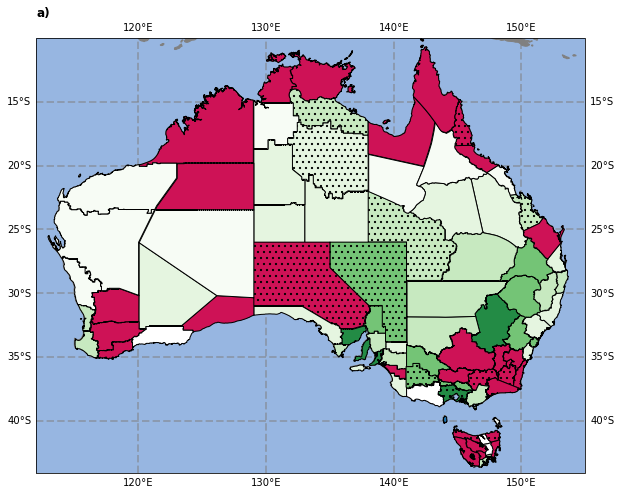

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([112, 155, -42, -10])
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND, color="grey")
plt.gcf().set_size_inches(16, 8)


df2 = ds.sel(lead_day=LEAD_DAY).to_dataframe()
df2["color"] = df2.apply(add_colours, axis=1)

def assign_hatching(row):
    if row["statistically_different"]:
        return '..'
    else:
        return None
df2["hatching"] = df2.apply(assign_hatching, axis=1)

for district in reader.records():
    if district.attributes["name"] == "National/All":
        continue
    new_district_name = mappingdict[district.attributes["name"]]

    shape_feature = ShapelyFeature(
        [district.geometry], 
        ccrs.PlateCarree(), 
        facecolor=df2.loc[new_district_name]["color"], 
        edgecolor="black",
        hatch=df2.loc[new_district_name]["hatching"], 
    )
    ax.add_feature(shape_feature)
ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=2,
    color='gray',
    alpha=0.5, 
    linestyle='--',
    zorder=0
)
ax.set_title("a)", loc='left', fontweight='bold')
plt.savefig(f"../figures/skill_score_lead_day{LEAD_DAY}.png", dpi=300)

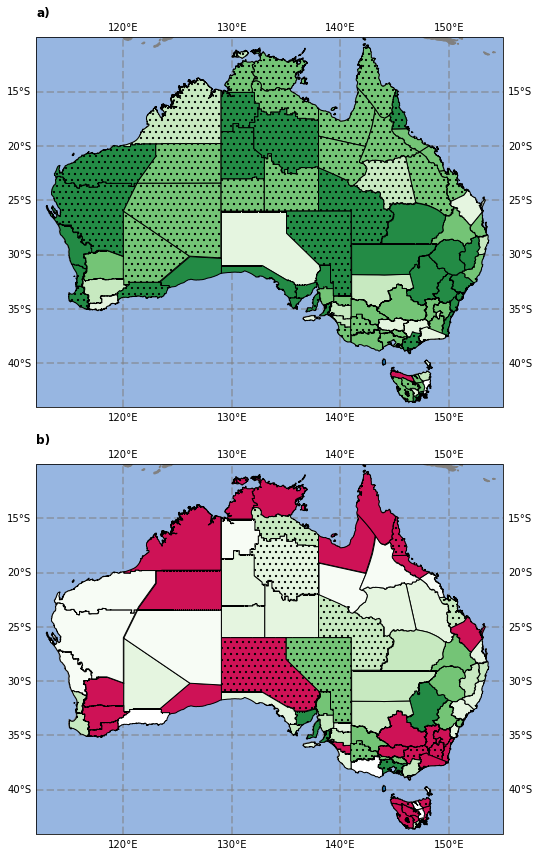

In [39]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
plt.gcf().set_size_inches(8, 12)

def assign_hatching(row):
    if row["statistically_different"]:
        return '..'
    else:
        return None
    
def create_sub_fig(axx, lead_day):
    axx.set_extent([112, 155, -42, -10])
    axx.add_feature(cf.OCEAN)
    axx.add_feature(cf.LAND, color="grey")

    df2 = ds.sel(lead_day=lead_day).to_dataframe()
    df2["color"] = df2.apply(add_colours, axis=1)
    df2["hatching"] = df2.apply(assign_hatching, axis=1)

    for district in reader.records():
        if district.attributes["name"] == "National/All":
            continue
        new_district_name = mappingdict[district.attributes["name"]]

        shape_feature = ShapelyFeature(
            [district.geometry], 
            ccrs.PlateCarree(), 
            facecolor=df2.loc[new_district_name]["color"], 
            edgecolor="black",
            hatch=df2.loc[new_district_name]["hatching"], 
        )
        axx.add_feature(shape_feature)
    axx.gridlines(
        crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5, 
        linestyle='--',
        zorder=0
    )
create_sub_fig(ax, 0)
create_sub_fig(ax2, 2)
ax.set_title("a)", loc='left', fontweight='bold')
ax2.set_title("b)", loc='left', fontweight='bold')
fig.tight_layout()
plt.savefig(f"../figures/skill_score_lead_day.png", dpi=300)

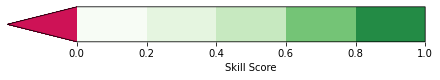

In [40]:
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')


cmap = (mpl.colors.ListedColormap(["#f7fcf5", "#e5f5e0", "#c7e9c0", "#74c476", "#238b45"])
.with_extremes(under="#ce1256"))
bounds = [0, 0.2, 0.4, 0.6, 0.8, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='min',
    extendfrac='auto',
    spacing='proportional',
    label='Skill Score',
)
plt.savefig(f"../figures/skill_score_colourbar.png", dpi=300)